# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 07/15/2022
* Student Name: Josh Gen
* Student Net ID: jdg9vr
* This URL: https://github.com/jdg9vr/game-monte-carlo/blob/main/FinalProjectSubmission.ipynb
* GitHub Repo URL: https://github.com/jdg9vr/game-monte-carlo

# The Monte Carlo Module

In [ ]:
import pandas as pd
import numpy as np
class Die:
    '''
    This class creates a die with weights and allows for changing of those weights as well as
    rolling of that die.
    INPUTS: 
        Faces (numpy array of strings or ints): the names of all the faces of the die
    '''
    def __init__(self, faces):
        self.faces = faces
        self.n = len(faces)
        self.weights = [1 for i in range(self.n)]
        self.__die = pd.DataFrame({'faces':self.faces, 'weights':self.weights})
    def change_weight(self, face, new_weight):
        '''
        PURPOSE:
            Change the weight of a specified face
        INPUTS:
            Face (string/int that matches an initialized face): Name of face to change
            New_weight (int/float): New weight to change specified face to
        OUTPUTS: No outputs
        '''
        if face not in self.__die.faces.values:
            raise ValueError(f"{face} is not in die.")
        elif type(new_weight) != int and type(new_weight) != float:
            raise TypeError("The inputted weight is not a number")
        else:
            self.__die.loc[self.__die.faces==face, 'weights'] = new_weight
    def roll(self, rolls=1):
        '''
        PURPOSE:
            Roll the die a certain amount of times according to the stored weights
        INPUTS: 
            Rolls (int): Number of rolls of the die (OPTIONAL - defaults to 1)
        OUTPUTS:
            A list of the results of each roll
        '''
        return [self.__die.faces.sample(weights=self.__die.weights).values[0] for i in range(rolls)]
    def show_die(self):
        '''
        PURPOSE:
            Show the die's faces and weights
        INPUTS: No inputs
        OUTPUTS:
            Pandas DataFrame of the die's faces and weights in seperate columns
        '''
        return self.__die


class Game:
    '''
    This class creates a game in which any number of already specified die are rolled a specified
    amount of times and resutls can be shown in two different formats.
    INPUTS: 
        die_list (list): a list of already initialized die using the Die class.
    '''
    def __init__(self, die_list):
        self.die_list = die_list
    def play(self, n_times):
        '''
        PURPOSE:
            Roll each of the die a specified number of times
        INPUTS: 
            n_times (int): Number of times to roll each die
        OUTPUTS: No outputs
        '''
        self.__roll_results = pd.DataFrame([die.roll(n_times) for die in self.die_list]).T
        self.__roll_results.index.name = 'roll'
    def show_results(self, view="wide"):
        '''
        PURPOSE:
            Show the game's results
        INPUTS: 
            View (str): Takes two options, wide or narrow, and formats the results accordingly 
                (OPTIONAL - defaults to wide)
                    In wide format, the columns are the die and the rows are the roll numbers
                    In narrow format, the index has both the die and roll number and there is a sole column for face rolled
        OUTPUTS:
            Pandas DataFrame of the faces rolled in specified view format
        '''
        if view == 'wide':
            return self.__roll_results
        elif view == 'narrow':
            return self.__roll_results.stack()
        else:
            raise ValueError("The inputted view format is not applicable, try \"wide\" or \"narrow\"")


class Analyzer:
    '''
    PURPOSE:
        This class takes a game object and performs analyses on it, including number of jackpots,
        number of unique combinations, and a sparse dataset of counts of each face by roll.
    INPUTS:
        Game object
    '''
    def __init__(self, game, n_times):
        self.game = game
        self.game.play(n_times)
        self.game_results = self.game.show_results()
    def jackpot(self):
        '''
        PURPOSE:
            Count the amount of jackpots in the game, as defined as when all die in a roll have the same face.
        INPUTS: No inputs
        OUTPUTS:
            The count of jackpots as an integer
        '''
        self.jackpot_count = 0
        self.jackpots = pd.DataFrame()
        for i in range(len(self.game_results)):
            if len(self.game_results.iloc[i,:].unique()) == 1:
                self.jackpot_count += 1
                self.jackpots = pd.concat([self.jackpots, pd.DataFrame(self.game_results.iloc[i,:]).T])
        return self.jackpot_count
    def combo(self):
        '''
        PURPOSE:
            Show a table that has the unique counts of each combination of rolls that was rolled.
        INPUTS: No inputs
        OUTPUTS:
            A dataframe of counts of unique rolls (order does not matter)
        '''
        self.combos = self.game_results.apply(lambda x: pd.Series(sorted(x)), 1).value_counts().to_frame('size')
        return self.combos
    def face_counts(self):
        '''
        PURPOSE: Show a table of counts of each face on each roll
        INPUTS: No inputs
        OUTPUTS:
            A sparse dataframe of counts of each face on each roll
        '''
        self.face_counts_per_roll = self.game_results.apply(lambda x: x.value_counts(), 1).fillna(0)
        return self.face_counts_per_roll


# Test Module

In [ ]:
import pandas as pd
import numpy as np
import unittest
from game_monte_carlo.montecarlo import Die
from game_monte_carlo.montecarlo import Game
from game_monte_carlo.montecarlo import Analyzer

class MontecarloTestSuites(unittest.TestCase):
    def test_1_show_weights(self):
        '''
        PURPOSE:
            Test the show weights function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        # test that show_weights shows the die weights
        myDie = Die(np.array(['first', 'second', 'third', 'fourth', 'fifth']))
        
        expected = pd.DataFrame({'faces':['first', 'second', 'third', 'fourth', 'fifth'], 
                                 'weights':[1, 1, 1, 1, 1]})
        check = myDie.show_die().equals(expected)
        self.assertTrue(check)
    def test_2_change_weight(self):
        '''
        PURPOSE:
            Test the change function including errors
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        # change weight and see if it was changed
        myDie = Die(np.array(['first', 'second', 'third', 'fourth', 'fifth']))
        myDie.change_weight('first', 100)
        
        expected = 100
        self.assertEqual(myDie.show_die()['weights'].values[0], expected)
        with self.assertRaises(ValueError):
            myDie.change_weight('whale', 100)
        with self.assertRaises(TypeError):
            myDie.change_weight('first', 'new')
    def test_3_roll(self):
        '''
        PURPOSE:
            Test the roll function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        myDie = Die(np.array(['first', 'second']))
        myDie.change_weight('second', 0)
        roll_1 = myDie.roll()[0]
        self.assertEqual(roll_1, 'first')
    def test_4_play_and_show_results(self):
        '''
        PURPOSE:
            Test the play function and show results function and errors
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        unfair_coin = Die(['heads', 'tails'])
        unfair_coin.change_weight('tails', 0)
        unfair_die = Die([1, 2, 3, 4, 5,6])
        unfair_die.change_weight(1, 0)
        unfair_die.change_weight(2, 0)
        unfair_die.change_weight(3, 0)
        unfair_die.change_weight(4, 0)
        unfair_die.change_weight(5, 0)
        myGame = Game([unfair_coin, unfair_die])
        myGame.play(10)
        
        expected = pd.DataFrame([np.repeat('heads', 10), np.repeat(6, 10)]).T
        check = myGame.show_results().equals(expected)
        self.assertTrue(check)
        
        with self.assertRaises(ValueError):
            myGame.show_results('thin')
    def test_5_jackpot(self):
        '''
        PURPOSE:
            Test the jackpot function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        unfair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die.change_weight(1, 0)
        unfair_die.change_weight(2, 0)
        unfair_die.change_weight(3, 0)
        unfair_die.change_weight(4, 0)
        unfair_die.change_weight(5, 0)
        unfair_die2 = Die([1, 2, 3, 4, 5, 6])
        unfair_die2.change_weight(1, 0)
        unfair_die2.change_weight(2, 0)
        unfair_die2.change_weight(3, 0)
        unfair_die2.change_weight(4, 0)
        unfair_die2.change_weight(6, 0)
        myGameDie = Game([unfair_die, unfair_die2])
        myGameDie.play(10)
        dieAnalysis = Analyzer(myGameDie, 100)
        check = dieAnalysis.jackpot()==0
        self.assertTrue(check)
    def test_6_jackpots(self):
        '''
        PURPOSE:
            Test the jackpot dataframe resulting from the jackpot function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        fair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die.change_weight(1, 0)
        unfair_die.change_weight(2, 0)
        unfair_die.change_weight(3, 0)
        unfair_die.change_weight(4, 0)
        unfair_die.change_weight(5, 0)
        kinda_fair_die = Die([1, 2, 3, 4, 5, 6])
        kinda_fair_die.change_weight(1, 2)
        kinda_fair_die.change_weight(3, 2)
        kinda_fair_die.change_weight(6, 2)
        myGameDie = Game([fair_die, unfair_die, kinda_fair_die])
        myGameDie.play(10)
        dieAnalysis = Analyzer(myGameDie, 1000)
        dieAnalysis.jackpot()
        check = dieAnalysis.jackpots.apply(lambda x: len(x.unique())-1, 1).sum() == 0
        self.assertTrue(check)
    def test_7_combo(self):
        '''
        PURPOSE:
            Test the combo function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        fair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die.change_weight(1, 0)
        unfair_die.change_weight(2, 0)
        unfair_die.change_weight(3, 0)
        unfair_die.change_weight(4, 0)
        unfair_die.change_weight(5, 0)
        kinda_fair_die = Die([1, 2, 3, 4, 5, 6])
        kinda_fair_die.change_weight(1, 2)
        kinda_fair_die.change_weight(3, 2)
        kinda_fair_die.change_weight(6, 2)
        myGameDie = Game([fair_die, unfair_die, kinda_fair_die])
        myGameDie.play(10)
        dieAnalysis = Analyzer(myGameDie, 1000)
        self.assertTrue(isinstance(dieAnalysis.combo().index, pd.MultiIndex))
    def test_8_face_counts(self):
        '''
        PURPOSE:
            Test the face counts function
        INPUTS: No inputs
        OUTPUTS:
            Ok for successful test
        '''
        unfair_die = Die([1, 2, 3, 4, 5, 6])
        unfair_die.change_weight(1, 0)
        unfair_die.change_weight(2, 0)
        unfair_die.change_weight(3, 0)
        unfair_die.change_weight(4, 0)
        unfair_die.change_weight(5, 0)
        unfair_die2 = Die([1, 2, 3, 4, 5, 6])
        unfair_die2.change_weight(1, 0)
        unfair_die2.change_weight(2, 0)
        unfair_die2.change_weight(3, 0)
        unfair_die2.change_weight(4, 0)
        unfair_die2.change_weight(6, 0)
        game_dies = [unfair_die, unfair_die2]
        myGameDie = Game(game_dies)
        myGameDie.play(10)
        n = 100
        dieAnalysis = Analyzer(myGameDie, n)
        check = dieAnalysis.face_counts().shape == (n, len(game_dies))
        self.assertTrue(check)
        

if __name__ == '__main__':
    unittest.main(verbosity=3)

# Test Results

test_1_show_weights (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_2_change_weight (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_3_roll (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_4_play_and_show_results (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_5_jackpot (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_6_jackpots (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_7_combo (__main__.MontecarloTestSuites)
PURPOSE: ... ok
test_8_face_counts (__main__.MontecarloTestSuites)
PURPOSE: ... ok

----------------------------------------------------------------------
Ran 8 tests in 2.414s

OK

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

In [1]:
import pandas as pd
import numpy as np
from game_monte_carlo import Die
from game_monte_carlo import Game
from game_monte_carlo import Analyzer
import matplotlib.pyplot as plt
fair_coin = Die(np.array(['heads', 'tails']))
unfair_coin = Die(np.array(['heads', 'tails']))
unfair_coin.change_weight('heads', 5)
fairGame = Game([fair_coin, fair_coin, fair_coin])
unfairGame = Game([unfair_coin, unfair_coin, fair_coin])
fairAnalyzer = Analyzer(fairGame, 1000)
unfairAnalyzer = Analyzer(unfairGame, 1000)
fairAnalyzer.jackpot()/1000

Montecarlo game loaded!


0.243

In [2]:
unfairAnalyzer.jackpot()/1000

0.393

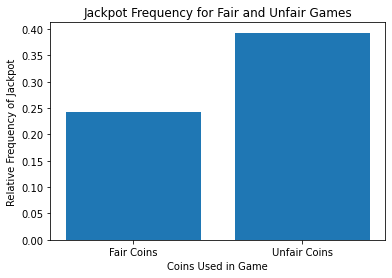

In [3]:
plt.bar(['Fair Coins', 'Unfair Coins'], [fairAnalyzer.jackpot()/1000, unfairAnalyzer.jackpot()/1000]);
plt.xlabel("Coins Used in Game")
plt.ylabel("Relative Frequency of Jackpot")
plt.title('Jackpot Frequency for Fair and Unfair Games');

## Scenario 2

In [4]:
fairDie = Die([1, 2, 3, 4, 5, 6])
unfairDie1 = Die([1, 2, 3, 4, 5, 6])
unfairDie1.change_weight(6, 5)
unfairDie2 = Die([1, 2, 3, 4, 5, 6])
unfairDie2.change_weight(1, 5)
fairDieGame = Game([fairDie, fairDie, fairDie, fairDie, fairDie])
unfairDieGame = Game([fairDie, fairDie, unfairDie1, unfairDie1, unfairDie2])
fairDieAnalyzer = Analyzer(fairDieGame, 10000)
unfairDieAnalyzer = Analyzer(unfairDieGame, 10000)
fairDieAnalyzer.jackpot()/10000

0.0005

In [5]:
unfairDieAnalyzer.jackpot()/10000

0.0014

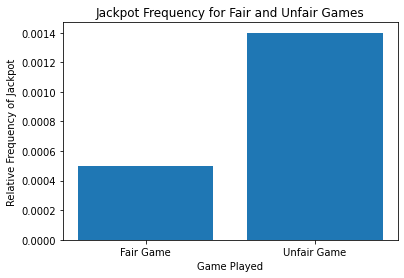

In [6]:
plt.bar(['Fair Game', 'Unfair Game'], [fairDieAnalyzer.jackpot()/10000, unfairDieAnalyzer.jackpot()/10000]);
plt.xlabel("Game Played")
plt.ylabel("Relative Frequency of Jackpot")
plt.title('Jackpot Frequency for Fair and Unfair Games');

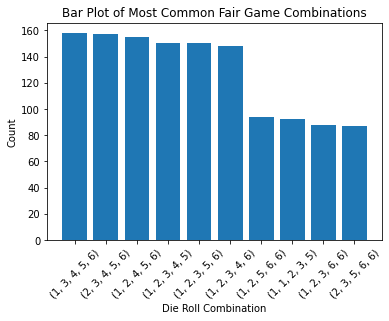

In [7]:
frequent_fair_combos = fairDieAnalyzer.combo()[0:10]
plt.bar(["".join(str(tup)) for tup in frequent_fair_combos.index.tolist()], frequent_fair_combos['size'].to_list());
plt.xticks(rotation=45)
plt.xlabel("Die Roll Combination")
plt.ylabel("Count")
plt.title('Bar Plot of Most Common Fair Game Combinations');

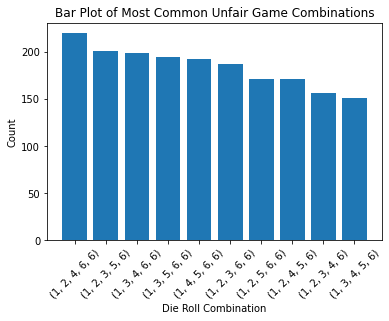

In [8]:
frequent_unfair_combos = unfairDieAnalyzer.combo()[0:10]
plt.bar(["".join(str(tup)) for tup in frequent_unfair_combos.index.tolist()], frequent_unfair_combos['size'].to_list());
plt.xticks(rotation=45)
plt.xlabel("Die Roll Combination")
plt.ylabel("Count")
plt.title('Bar Plot of Most Common Unfair Game Combinations');

## Scenario 3

In [9]:
letterDie = Die(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", 
                 "p", "q", "r", "s", "t", 'u', 'v', 'w', 'x', 'y', "z"])
letterDie.weights = [8.4966, 2.0720, 4.5388, 3.3844, 11.1607, 1.8121, 2.4705, 3.0034, 7.5448, 
                     0.1965, 1.1016, 5.4893, 3.0129, 6.6544, 7.1635, 3.1671, 0.1962, 7.5809, 
                     5.7351, 6.9509, 3.6308, 1.0074, 1.2899, 0.2902, 1.7779 ,0.2722]
letterDieGame = Game([letterDie, letterDie, letterDie, letterDie, letterDie])
letterDieAnalyzer = Analyzer(letterDieGame, 1000)
faces = ["".join(word) for word in letterDieAnalyzer.combo().index.tolist()]
wordle_guesses = pd.read_csv('valid_guesses.csv')
wordle_guesses[wordle_guesses['word'].isin(faces)]

,word
2436,dorty


In [10]:
len(wordle_guesses[wordle_guesses['word'].isin(faces)])/1000

0.001

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [11]:
!ls -lRF -o

total 352
-rw-r--r--  1 joshgen   4596 Jul 11 11:18 FinalProjectSubmission.ipynb
-rw-r--r--  1 joshgen   1065 Jul  8 09:32 LICENSE
-rw-r--r--  1 joshgen     18 Jul  8 09:32 README.md
drwxr-xr-x@ 4 joshgen    128 Jul 14 10:42 __pycache__/
drwxr-xr-x@ 3 joshgen     96 Jul 14 10:39 game-monte-carlo/
drwxr-xr-x@ 5 joshgen    160 Jul 14 18:34 game_monte_carlo/
drwxr-xr-x@ 6 joshgen    192 Jul 14 10:32 game_monte_carlo.egg-info/
-rw-r--r--  1 joshgen   6460 Jul 14 10:41 montecarlo_tests.py
-rw-r--r--@ 1 joshgen    627 Jul 14 10:42 montecarlo_tests.txt
-rw-r--r--  1 joshgen  69337 Jul 14 18:35 scenarios.ipynb
-rw-r--r--  1 joshgen    301 Jul 14 10:39 setup.py
-rw-r--r--@ 1 joshgen  74605 Jul 14 09:56 valid_guesses.csv

./__pycache__:
total 32
-rw-r--r--  1 joshgen  6685 Jul 13 22:01 montecarlo.cpython-310.pyc
-rw-r--r--  1 joshgen  5863 Jul 14 10:42 montecarlo_tests.cpython-310.pyc

./game-monte-carlo:
total 0
drwxr-xr-x@ 4 joshgen  128 Jul 14 10:31 __pycache__/

./game-monte-carlo/__pycache_

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [13]:
!pip3 install -e .

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Obtaining file:///Users/joshgen/Documents/Code/MSDS/game-monte-carlo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: game-monte-carlo
    Found existing installation: game-monte-carlo 0.1
    Uninstalling game-monte-carlo-0.1:
      Successfully uninstalled game-monte-carlo-0.1
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Running setup.py develop for game-monte-carlo
